# Challenge Problem in Hierarchical Surrogate Modeling

## Primer

Many predictions in cosmology are fundamentally predictions about *populations*, rather than predictions for the outcomes of individual events or objects. So, for example, we might want to predict the mass function of a simulated population of halos, or a correlation function computed from a finite set of particles in a simulated density field. 

When using cosmological simulations to make predictions for the distribution of astronomically observed galaxies, it is common for the modeling to take place in two distinct phases. The first phase is to run an extremely expensive gravity-only simulation, which makes predictions for the distribution of dark matter halos. The second phase is to apply additional modeling to those halos, to account for astrophysics that was not included in the simulation itself. This challenge problem is primarily concerned with this second phase of modeling, which is done at fixed cosmology.

A cosmological simulation has millions to billions of dark matter halos. And these phase-two models are applied on a per-halo basis, so that predictions can be made for the statistics of the halo population. For this reason, it can be highly beneficial to build emulators/surrogates for the models applied to each individual halo. The surrogate models provide stand-ins for how the actual models augment/modify each member of the large halo population. 

For the *accuracy* of the surrogate model, we can usually tolerate errors at the $\sim1-2\%$ level without contributing too much to the overall error budget. For the performance of the model, the training time is not so important as the *evaluation time*: if our simulation had a billion halos, that would mean we'd need to evaluate our surrogate model a billion times in order to make the prediction for the statistics of the halo population. While a small GP might be too inaccurate, a deep neural network with a complex topology would be too expensive to evaluate so many times just to make a *single* prediction for the halo population.

What makes this modeling *hierarchical* is that in this science application, we want to make more than a single prediction. We will need to make millions of such predictions, where each prediction is for some summary statistic of the galaxy population that is generated by applying our surrogate model(s) to each individual halo in the simulation. So, at a higher level of the hierarchy, we have a model with parameters $\{\alpha_{\rm i}\},$ and we have some modeling function $\mathcal{F}_{\alpha_i}$ that maps parameters $\{\beta_{\rm j}\}$ onto each halo; at the next level of the hierarchy, we have functions $\mathcal{G}_{\beta_{\rm j}}$ that are applied to each halo; it is the functions $\mathcal{G}_{\beta_{\rm j}}$ that transform the halo population into a galaxy population; the functions $\mathcal{G}$ are the functions for which we need fast-evaluating surrogate models. 

In the progression of the hierarchy, we want to carry out Bayesian inference on the parameters $\{\alpha_{\rm i}\}.$ The $\alpha$ parameters could be as simple as specifying a stellar-mass-to-halo-mass relation, or as complicated as the parameters regulating the behavior of a complex system of ODEs (like in "semi-analytic modeling" of galaxies). Either way, conducting Bayesian inference on the $\alpha$ parameters may require computing a million likelihood evaluations in an MCMC, for example. 

For the computation of each likelihood, the way we make predictions that can be compared to data is to generate a synthetic galaxy population, and to compare some summary statistic of that synthetic galaxy population to the corresponding summary statistic measured in real data. Each individual computation of the $\{\alpha_{\rm i}\}$-model likelihood therefore requires evaluation of the model $\mathcal{G}_{\beta_{\rm j}}$ on each of the million-to-billion halos. 

This is why this set of science applications benefits so much from surrogate models that, once trained, *evaluate very quickly in batches.* The functions $\mathcal{G}_{\beta_{\rm j}}$ are typically analytical functions, numerical integrals, or solutions to ODEs. And while these functions themselves are typically too expensive to run in the MCMC over the parameters $\{\alpha_{\rm i}\},$ on the other hand the $\mathcal{G}_{\beta_{\rm j}}$ functions are usually cheap enough to evaluate $\mathcal{O}(10^{5-6})$ times without too much effort, and so in these applications there is no problem at all generating copious amounts of extremely high-quality training data. 


## Setup
Suppose we wish to make a prediction for the spatial distribution of galaxies. Well, some galaxies are *central* galaxies that are the most massive galaxy in their local neighborhood, while other galaxies are *satellite* galaxies that are in orbit around their (unique) associated central. If we will be using a cosmological simulation to make our predictions, then predicting the positions of central galaxies is easy: we just place a central galaxy at the center of every dark matter halo, which is provided directly by the simulation. Making predictions for satellite galaxies, on the other hand, is complicated. All we know is that the satellites belong *somewhere* inside the halo, but the simulation does not tell us the their positions. And so we need to do some additional modeling in order to map satellites onto dark matter halos. Once we have such a model, we can then compare our synthetic universe of galaxies to the real one, and use Bayesian inference to try to infer the correct model for how satellite galaxies are distributed within their halos. The rest of these notes add flesh out this modeling and use this problem to motivate the computational needs of hierarchical surrogate modeling




In [1]:
%matplotlib inline

## Training data for a surrogate model of Halo profiles w/ splashback

These data can be found at the following URL:

https://portal.nersc.gov/project/hacc/aphearin/splashback_training/

In [2]:
r_by_rt = np.load("DATA/r_by_rt.npy")
data = np.load("DATA/dk14_ds_tabulation.npy")
rs = data[:, 0]
alpha = data[:, 1]
beta = data[:, 2]
gamma = data[:, 3]

log_menc = data[:, 4:]

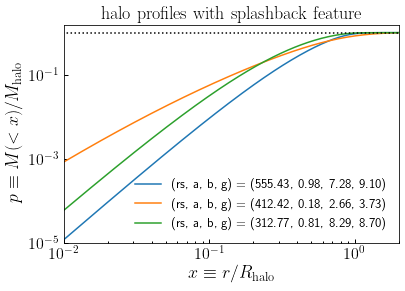

In [3]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.01, 2)
ylim = ax.set_ylim(1e-5, 1.5)
__=ax.loglog()

iplot = 0
msg = '(rs, a, b, g) = ({0:.2f}, {1:.2f}, {2:.2f}, {3:.2f})'
label0 = msg.format(rs[iplot], alpha[iplot], beta[iplot], gamma[iplot])
__=ax.plot(r_by_rt, 10**log_menc[iplot, :], label=label0)

iplot = 300
msg = '(rs, a, b, g) = ({0:.2f}, {1:.2f}, {2:.2f}, {3:.2f})'
label1 = msg.format(rs[iplot], alpha[iplot], beta[iplot], gamma[iplot])
__=ax.plot(r_by_rt, 10**log_menc[iplot, :], label=label1)

iplot = 3000
msg = '(rs, a, b, g) = ({0:.2f}, {1:.2f}, {2:.2f}, {3:.2f})'
label2 = msg.format(rs[iplot], alpha[iplot], beta[iplot], gamma[iplot])
__=ax.plot(r_by_rt, 10**log_menc[iplot, :], label=label2)

xlabel = ax.set_xlabel(r'$x\equiv r/R_{\rm halo}$')
ylabel = ax.set_ylabel(r'$p\equiv M(<x)/M_{\rm halo}$')
title = ax.set_title(r'${\rm halo\ profiles\ with\ splashback\ feature}$')
__=ax.plot(np.logspace(-5, 5, 1000), np.ones(1000), ':', color='k')
leg = ax.legend(fontsize=13)
fig.savefig('menc_dk14.png', bbox_extra_artists=[xlabel, ylabel], 
            bbox_inches='tight', dpi=200)


## Generating Monte Carlo realizations

In order to generate a Monte Carlo realization of one of these profiles using the [transformation of probabilities](https://github.com/jbailinua/probability/), what we actually need is the _inverse_ cumulative mass function, $x=\mathcal{F}(p) = M^{-1}(p).$ Here's an example of how that works:

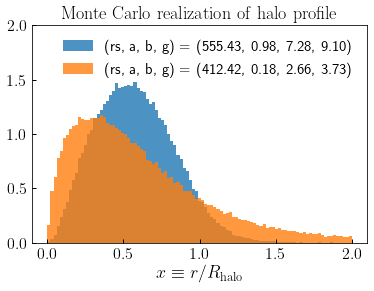

In [4]:
npts_to_generate = int(1e5)
pran = np.random.random(npts_to_generate)
xran = np.interp(np.log10(pran), log_menc[0, :], np.log10(r_by_rt))
xran2 = np.interp(np.log10(pran), log_menc[300, :], np.log10(r_by_rt))

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 2)
xbins = np.linspace(0, 2, 100)
__=ax.hist(10**xran, bins=xbins, density=True, alpha=0.8, label=label0)
__=ax.hist(10**xran2, bins=xbins, density=True, alpha=0.8, label=label1)

xlabel = ax.set_xlabel(r'$x\equiv r/R_{\rm halo}$')
title = ax.set_title(r'${\rm Monte\ Carlo\ realization\ of\ halo\ profile}$')
leg = ax.legend()

The above technique works by digitizing the underlying model, and numerically inverting the tabulated profile. But that is entirely unworkable for models with even a few dimensions, and so this is a natural problem for surrogate modeling. 